# Pràctica 1: Identificació d'Idiomes amb N-grames de Caràcters

**Assignatura:** Processament del Llenguatge Humà  

## Objectiu
Implementar un sistema d'identificació automàtica d'idioma per a sis llengües europees:
- 🇬🇧 Anglès (eng)
- 🇪🇸 Castellà (spa)
- 🇳🇱 Neerlandès (nld)
- 🇩🇪 Alemany (deu)
- 🇮🇹 Italià (ita)
- 🇫🇷 Francès (fra)

**Metodologia:** 
- Models de llenguatge basats en **n-grames de caràcters** ($n = 1, 2, 3, 4, 5$).
- Comparació de tècniques de suavitzat: **Lidstone** i **Back-off**.
- Experimentació per trobar la combinació òptima de $n$ i mètode de suavitzat.

## 1. Importació de llibreries

In [1]:
import re
import string
import os
import math
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

import spacy

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

DATA_DIR = "langId"
LANGUAGES = {
    "eng": "Anglès",
    "spa": "Castellà", 
    "nld": "Neerlandès",
    "deu": "Alemany",
    "ita": "Italià",
    "fra": "Francès"
}

N_GRAM_SIZES = [1, 2, 3, 4, 5]  # Unigrames fins a 5-grames

print("Llibreries carregades correctament.")

Llibreries carregades correctament.


## 2. Càrrega de dades

Carreguem els fitxers d'entrenament (`_trn.txt`) i de test (`_tst.txt`) per a cada idioma. Cada fitxer conté una frase per línia (~30.000 frases d'entrenament i ~10.000 de test per idioma).

In [2]:
def load_corpus(lang_code, split="trn"):
    """Carrega un fitxer de text i retorna una llista de frases."""
    filepath = os.path.join(DATA_DIR, f"{lang_code}_{split}.txt")
    with open(filepath, "r", encoding="utf-8") as f:
        sentences = [line.strip() for line in f if line.strip()]
    return sentences

# Carregar tots els corpus
train_data = {lang: load_corpus(lang, "trn") for lang in LANGUAGES}
test_data  = {lang: load_corpus(lang, "tst") for lang in LANGUAGES}

# Resum de les dades carregades
print(f"{'Idioma':<15} {'Train':>8} {'Test':>8}")
print("-" * 33)
for lang in LANGUAGES:
    print(f"{LANGUAGES[lang]:<15} {len(train_data[lang]):>8,} {len(test_data[lang]):>8,}")

Idioma             Train     Test
---------------------------------
Anglès            29,935    9,987
Castellà          30,000   10,000
Neerlandès        30,000   10,000
Alemany           29,928    9,990
Italià            30,000   10,000
Francès           30,000   10,000


In [3]:
# Mostrem exemples de cada idioma
for lang in LANGUAGES:
    print(f"\n--- {LANGUAGES[lang]} (exemple) ---")
    print(train_data[lang][1][:120] + "...")


--- Anglès (exemple) ---
2	0.00 0.00% How the mighty have fallen....

--- Castellà (exemple) ---
2	A pesar de la organización del movimiento, su paisano, Abelande, critica la dispersión de las propuestas....

--- Neerlandès (exemple) ---
2	1/16 finale De wedstrijden werden op 12 januari 1930 gespeeld, de beslissingswedstrijd op 19 januari....

--- Alemany (exemple) ---
2	04.04.2014 – 09:54Touristik "Das Magazin für die Freiheit unterwegs": AUTO BILD launcht neue Zeitschrift REISEMOBIL Ha...

--- Italià (exemple) ---
2	Il kaiser di Kerpen, che dovrebbe tornare in pista mercoledì per la terza e ultima giornata, si è concesso un "turno d...

--- Francès (exemple) ---
2	Il a signé jeudi à l'issue du programme libre une encourageante 12e place....


## 3. Preprocés del text

Apliquem els passos de neteja indicats a l'enunciat:

1. **Eliminar dígits** — els números no aporten informació discriminativa per a l'idioma.
2. **Convertir a minúscula** — normalitzar majúscules/minúscules per reduir variabilitat.
3. **Substituir espais en blanc continus per un de sol** — regularitzar l'espaiat.
4. **Concatenar totes les frases amb doble espai** — els espais dobles serviran com a delimitador de frase, mantenint la informació de frontera.

In [4]:
def preprocess_sentence(sentence):
    """Preprocessa una frase individual."""
    text = re.sub(r'\d', '', sentence)       # 1. Eliminar dígits
    text = text.lower()                       # 2. Convertir a minúscula
    text = re.sub(r'\s+', ' ', text).strip()  # 3. Espais continus → un de sol
    return text

def preprocess_corpus(sentences):
    """Preprocessa tot un corpus: neteja cada frase i les concatena amb doble espai."""
    cleaned = [preprocess_sentence(s) for s in sentences]
    cleaned = [s for s in cleaned if s]  # Eliminar frases buides
    return "  ".join(cleaned)            # 4. Concatenar amb doble espai

# Exemple del preprocés
example = "  Hello World 123!   This is a TEST.  "
print(f"Original:      '{example}'")
print(f"Preprocessat:  '{preprocess_sentence(example)}'")

Original:      '  Hello World 123!   This is a TEST.  '
Preprocessat:  'hello world ! this is a test.'


In [5]:
# Applicar preprocés als corpus d'entrenament
train_corpus = {lang: preprocess_corpus(train_data[lang]) for lang in LANGUAGES}

# Estadístiques post-preprocés
print(f"{'Idioma':<15} {'Caràcters':>12} {'Caràcters únics':>16}")
print("-" * 45)
for lang in LANGUAGES:
    n_chars = len(train_corpus[lang])
    unique_chars = len(set(train_corpus[lang]))
    print(f"{LANGUAGES[lang]:<15} {n_chars:>12,} {unique_chars:>16}")

Idioma             Caràcters  Caràcters únics
---------------------------------------------
Anglès             3,635,803              399
Castellà           3,965,102              120
Neerlandès         3,173,458              384
Alemany            3,405,306              115
Italià             3,829,970              115
Francès            3,697,648              115


## 4. Extracció de n-grames de caràcters ($n = 1, 2, 3, 4, 5$)

Un **n-grama de caràcters** és una subseqüència de $n$ caràcters consecutius. Per exemple, per la paraula `"hola"`:
- **Unigrames** ($n=1$): `"h"`, `"o"`, `"l"`, `"a"`
- **Bigrames** ($n=2$): `"ho"`, `"ol"`, `"la"`
- **Trigrames** ($n=3$): `"hol"`, `"ola"`
- **4-grames** ($n=4$): `"hola"`

Cada idioma té combinacions de caràcters característiques. La qüestió clau és: **quin valor de $n$ captura millor les diferències entre idiomes?**

- $n$ petit (1-2): Capta distribucions generals de caràcters, però poca informació estructural.
- $n$ moderat (3): Bon equilibri entre discriminació i cobertura.
- $n$ gran (4-5): Més específic, però menys cobertura (més n-grames no vistos al test).

**Filtratge:** Eliminem els n-grames amb freqüència $< 5$ per reduir soroll.

Utilitzem **spaCy** per il·lustrar la tokenització i després extraiem els n-grames de caràcters.

In [6]:
def extract_ngrams(text, n):
    """Extreu tots els n-grames de caràcters d'un text i retorna un Counter."""
    ngrams = Counter()
    for i in range(len(text) - n + 1):
        ngram = text[i:i+n]
        ngrams[ngram] += 1
    return ngrams

def filter_ngrams(ngram_counts, min_count=5):
    """Elimina n-grames amb freqüència menor a min_count."""
    return Counter({ng: c for ng, c in ngram_counts.items() if c >= min_count})

# Demostració amb spaCy: tokenització + n-grames
nlp = spacy.blank("en")
demo_text = "Hello World, this is a language test."
doc = nlp(demo_text.lower())
tokens = [token.text for token in doc if not token.is_space]
print(f"Text:    '{demo_text}'")
print(f"Tokens:  {tokens}")
print()

# Exemple d'n-grames de caràcters
demo_processed = preprocess_sentence(demo_text)
for n in N_GRAM_SIZES:
    ngs = extract_ngrams(demo_processed, n)
    print(f"  {n}-grames ({len(ngs)} únics): {list(ngs.keys())[:8]}...")

Text:    'Hello World, this is a language test.'
Tokens:  ['hello', 'world', ',', 'this', 'is', 'a', 'language', 'test', '.']

  1-grames (17 únics): ['h', 'e', 'l', 'o', ' ', 'w', 'r', 'd']...
  2-grames (33 únics): ['he', 'el', 'll', 'lo', 'o ', ' w', 'wo', 'or']...
  3-grames (34 únics): ['hel', 'ell', 'llo', 'lo ', 'o w', ' wo', 'wor', 'orl']...
  4-grames (34 únics): ['hell', 'ello', 'llo ', 'lo w', 'o wo', ' wor', 'worl', 'orld']...
  5-grames (33 únics): ['hello', 'ello ', 'llo w', 'lo wo', 'o wor', ' worl', 'world', 'orld,']...


In [7]:
# Extreure i filtrar n-grames per cada idioma i cada n
raw_ngrams = {}   # {n: {lang: Counter}}
ngram_models_all = {}  # {n: {lang: Counter filtrat}}

for n in N_GRAM_SIZES:
    raw_ngrams[n] = {lang: extract_ngrams(train_corpus[lang], n) for lang in LANGUAGES}
    ngram_models_all[n] = {lang: filter_ngrams(raw_ngrams[n][lang], min_count=5) for lang in LANGUAGES}

# Taula resum
print(f"{'n':>2} | {'Idioma':<12} | {'Totals':>10} | {'Filtrats':>10} | {'Eliminats':>10}")
print("-" * 58)
for n in N_GRAM_SIZES:
    for lang in LANGUAGES:
        total = len(raw_ngrams[n][lang])
        filt = len(ngram_models_all[n][lang])
        pct = (1 - filt / total) * 100 if total > 0 else 0
        print(f"{n:>2} | {LANGUAGES[lang]:<12} | {total:>10,} | {filt:>10,} | {pct:>9.1f}%")
    print("-" * 58)

 n | Idioma       |     Totals |   Filtrats |  Eliminats
----------------------------------------------------------
 1 | Anglès       |        399 |         85 |      78.7%
 1 | Castellà     |        120 |         83 |      30.8%
 1 | Neerlandès   |        384 |        120 |      68.8%
 1 | Alemany      |        115 |         82 |      28.7%
 1 | Italià       |        115 |         94 |      18.3%
 1 | Francès      |        115 |         94 |      18.3%
----------------------------------------------------------
 2 | Anglès       |      2,369 |      1,221 |      48.5%
 2 | Castellà     |      2,311 |      1,464 |      36.7%
 2 | Neerlandès   |      3,068 |      1,430 |      53.4%
 2 | Alemany      |      2,266 |      1,469 |      35.2%
 2 | Italià       |      2,320 |      1,393 |      40.0%
 2 | Francès      |      2,359 |      1,530 |      35.1%
----------------------------------------------------------
 3 | Anglès       |     17,973 |      9,390 |      47.8%
 3 | Castellà     |     1

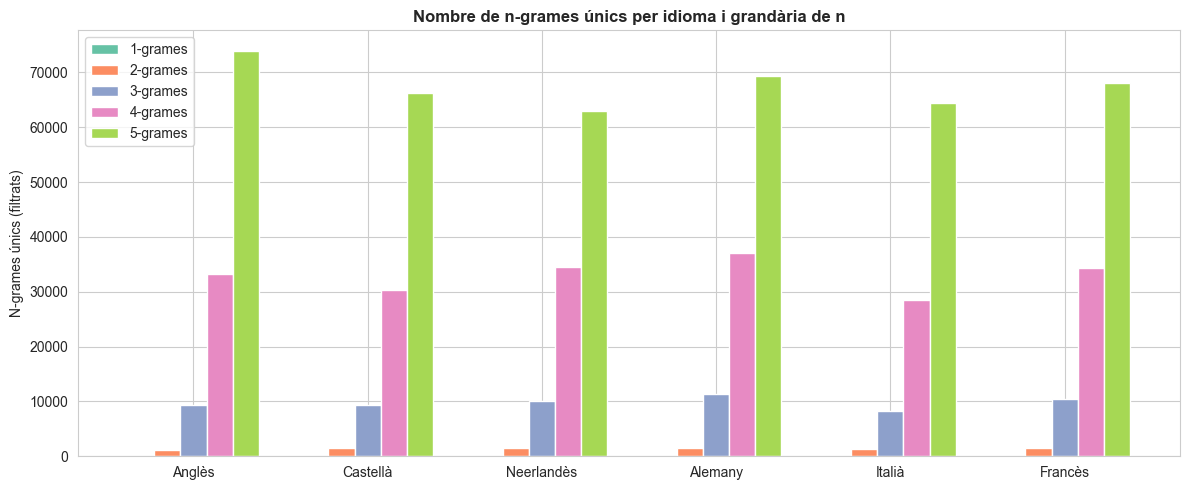

In [8]:
# Visualitzar: nombre de n-grames únics (filtrats) per n i idioma
fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(LANGUAGES))
width = 0.15
colors = sns.color_palette("Set2", len(N_GRAM_SIZES))

for i, n in enumerate(N_GRAM_SIZES):
    counts = [len(ngram_models_all[n][lang]) for lang in LANGUAGES]
    ax.bar(x + i * width, counts, width, label=f'{n}-grames', color=colors[i])

ax.set_xticks(x + width * 2)
ax.set_xticklabels([LANGUAGES[l] for l in LANGUAGES])
ax.set_ylabel('N-grames únics (filtrats)')
ax.set_title('Nombre de n-grames únics per idioma i grandària de n', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

## 5. Tècniques de suavitzat

### Problema dels n-grames no vistos
Si durant el test trobem un n-grama que no existeix al model d'entrenament, la seva probabilitat seria 0, i el $\log(0) = -\infty$. Necessitem tècniques de **suavitzat** per assignar probabilitat positiva a n-grames no vistos.

### 5.1 Suavitzat de Lidstone (additive smoothing)
Afegim un valor $\lambda > 0$ a cada comptatge:

$$P_{\text{Lidstone}}(w) = \frac{C(w) + \lambda}{N + \lambda \cdot V}$$

- $C(w)$: freqüència de l'n-grama $w$ (0 si no apareix o ha estat filtrat)
- $N$: total d'ocurrències al corpus filtrat
- $V$: mida del vocabulari d'n-grames
- $\lambda = 1$: Laplace; $0 < \lambda < 1$: sol funcionar millor

### 5.2 Back-off smoothing
Quan un n-grama no s'ha observat, **retrocedim** a un model d'ordre inferior ($(n{-}1)$-grames):

$$P_{\text{backoff}}(w_n | w_1 \ldots w_{n-1}) = \begin{cases} P_{\text{obs}}(w) & \text{si } C(w) > 0 \\ \alpha \cdot P_{\text{backoff}}^{(n-1)}(w') & \text{si } C(w) = 0 \end{cases}$$

On $\alpha$ és un factor de back-off que redistribueix la massa de probabilitat. En la nostra implementació:
- Si el n-grama existeix al model d'ordre $n$, usem la seva probabilitat.
- Si no, retrocedim al model d'ordre $n-1$, amb un factor de penalització $\alpha$.
- Si tampoc existeix, retrocedim a $n-2$, etc.
- Com a últim recurs (unigrames), apliquem suavitzat de Lidstone amb $\lambda$ petit.

**Avantatge**: El back-off aprofita la informació de les distribucions d'ordres inferiors, en comptes de simplement repartir massa uniformement (com fa Lidstone).

In [9]:
# Construir vocabulari global per a cada n (unió de train + test)
vocab_sizes = {}

for n in N_GRAM_SIZES:
    all_ngrams_n = set()
    # Des del train
    for lang in LANGUAGES:
        all_ngrams_n.update(raw_ngrams[n][lang].keys())
    # Des del test
    for lang in LANGUAGES:
        test_text = preprocess_corpus(test_data[lang])
        test_ngs = extract_ngrams(test_text, n)
        all_ngrams_n.update(test_ngs.keys())
    vocab_sizes[n] = len(all_ngrams_n)

print("Mida del vocabulari (V) per a cada n:")
for n in N_GRAM_SIZES:
    print(f"  {n}-grames: V = {vocab_sizes[n]:,}")

Mida del vocabulari (V) per a cada n:
  1-grames: V = 814
  2-grames: V = 6,018
  3-grames: V = 49,187
  4-grames: V = 275,573
  5-grames: V = 989,169


In [10]:
class LidstoneNgramModel:
    """Model de llenguatge basat en n-grames amb suavitzat de Lidstone."""
    
    def __init__(self, ngram_counts, vocab_size, n, lam=0.1):
        self.counts = ngram_counts
        self.N = sum(ngram_counts.values())
        self.V = vocab_size
        self.n = n
        self.lam = lam
    
    def log_prob_ngram(self, ngram):
        """log P(ngram) amb suavitzat de Lidstone."""
        count = self.counts.get(ngram, 0)
        return math.log((count + self.lam) / (self.N + self.lam * self.V))
    
    def log_prob_text(self, text):
        """Log-probabilitat total d'un text."""
        if len(text) < self.n:
            return float('-inf')
        total = 0.0
        for i in range(len(text) - self.n + 1):
            total += self.log_prob_ngram(text[i:i+self.n])
        return total

print("Classe LidstoneNgramModel definida.")

Classe LidstoneNgramModel definida.


In [11]:
class BackoffNgramModel:
    """Model de llenguatge amb back-off: retrocedeix a n-grames d'ordre inferior."""
    
    def __init__(self, ngram_counts_by_n, vocab_sizes, max_n, alpha=0.4, lam=0.01):
        """
        Args:
            ngram_counts_by_n: dict {n: Counter} amb comptatges filtrats per cada n.
            vocab_sizes: dict {n: int} amb la mida del vocabulari per cada n.
            max_n: ordre màxim dels n-grames.
            alpha: factor de penalització al retrocedir (0 < alpha < 1).
            lam: lambda per al suavitzat de Lidstone de l'últim nivell (unigrames).
        """
        self.counts = ngram_counts_by_n  # {n: Counter}
        self.totals = {n: sum(c.values()) for n, c in ngram_counts_by_n.items()}
        self.vocab_sizes = vocab_sizes
        self.max_n = max_n
        self.alpha = alpha
        self.lam = lam
    
    def log_prob_ngram(self, ngram):
        """Calcula log P(ngram) amb back-off recursiu."""
        n = len(ngram)
        
        # Si l'n-grama existeix al model d'ordre n, usar probabilitat observada
        if n in self.counts and self.counts[n].get(ngram, 0) > 0:
            prob = self.counts[n][ngram] / self.totals[n]
            return math.log(prob)
        
        # Back-off: retrocedir a n-1, amb penalització alpha
        if n > 1:
            # Retrocedim al sufixe de longitud n-1
            shorter = ngram[1:]  # usar el sufix
            return math.log(self.alpha) + self.log_prob_ngram(shorter)
        
        # Últim recurs: unigrama amb Lidstone
        count = self.counts.get(1, Counter()).get(ngram, 0)
        N = self.totals.get(1, 1)
        V = self.vocab_sizes.get(1, 1)
        return math.log((count + self.lam) / (N + self.lam * V))
    
    def log_prob_text(self, text):
        """Log-probabilitat total d'un text usant n-grames d'ordre max_n."""
        if len(text) < self.max_n:
            return float('-inf')
        total = 0.0
        for i in range(len(text) - self.max_n + 1):
            ngram = text[i:i + self.max_n]
            total += self.log_prob_ngram(ngram)
        return total

print("Classe BackoffNgramModel definida.")

Classe BackoffNgramModel definida.


## 6. Experimentació: Comparació de n-grames i mètodes de suavitzat

### Disseny experimental
Comparem totes les combinacions de:
- **Ordre dels n-grames**: $n \in \{1, 2, 3, 4, 5\}$
- **Mètode de suavitzat**: Lidstone ($\lambda = 0.1$) vs. Back-off ($\alpha = 0.4$)

Primer fem una passada ràpida per veure les tendències, i després optimitzarem els hiperparàmetres del millor mètode.

In [12]:
def classify_sentence(sentence, models, n):
    """Classifica una frase: retorna l'idioma amb major log-probabilitat."""
    text = preprocess_sentence(sentence)
    if len(text) < n:
        return None
    best_lang = None
    best_score = float('-inf')
    for lang, model in models.items():
        score = model.log_prob_text(text)
        if score > best_score:
            best_score = score
            best_lang = lang
    return best_lang

def evaluate_models(models, test_data, n):
    """Avalua un conjunt de models sobre tot el test. Retorna accuracy global."""
    correct = 0
    total = 0
    for true_lang in LANGUAGES:
        for sentence in test_data[true_lang]:
            pred = classify_sentence(sentence, models, n)
            if pred is not None:
                total += 1
                if pred == true_lang:
                    correct += 1
    return correct / total if total > 0 else 0

print("Funcions de classificació i avaluació definides.")

Funcions de classificació i avaluació definides.


In [13]:
# Comparació: Lidstone vs Back-off per cada n
comparison_results = []

for n in N_GRAM_SIZES:
    # --- LIDSTONE ---
    lidstone_models = {
        lang: LidstoneNgramModel(ngram_models_all[n][lang], vocab_sizes[n], n, lam=0.1)
        for lang in LANGUAGES
    }
    acc_lidstone = evaluate_models(lidstone_models, test_data, n)
    comparison_results.append({'n': n, 'mètode': 'Lidstone (λ=0.1)', 'accuracy': acc_lidstone})
    print(f"n={n}, Lidstone (λ=0.1):  {acc_lidstone:.4f} ({acc_lidstone*100:.2f}%)")
    
    # --- BACK-OFF ---
    # Per al back-off necessitem els models de tots els ordres <= n
    backoff_models = {}
    for lang in LANGUAGES:
        counts_by_n = {k: ngram_models_all[k][lang] for k in range(1, n+1)}
        vs = {k: vocab_sizes[k] for k in range(1, n+1)}
        backoff_models[lang] = BackoffNgramModel(counts_by_n, vs, max_n=n, alpha=0.4, lam=0.01)
    
    acc_backoff = evaluate_models(backoff_models, test_data, n)
    comparison_results.append({'n': n, 'mètode': 'Back-off (α=0.4)', 'accuracy': acc_backoff})
    print(f"n={n}, Back-off (α=0.4):  {acc_backoff:.4f} ({acc_backoff*100:.2f}%)")
    print()

df_comparison = pd.DataFrame(comparison_results)
print("\n=== Resum ===")
print(df_comparison.pivot(index='n', columns='mètode', values='accuracy').to_string(float_format='{:.4f}'.format))

n=1, Lidstone (λ=0.1):  0.9359 (93.59%)
n=1, Back-off (α=0.4):  0.9359 (93.59%)

n=2, Lidstone (λ=0.1):  0.9944 (99.44%)
n=2, Back-off (α=0.4):  0.9911 (99.11%)

n=3, Lidstone (λ=0.1):  0.9987 (99.87%)
n=3, Back-off (α=0.4):  0.9961 (99.61%)

n=4, Lidstone (λ=0.1):  0.9996 (99.96%)
n=4, Back-off (α=0.4):  0.9968 (99.68%)

n=5, Lidstone (λ=0.1):  0.9997 (99.97%)
n=5, Back-off (α=0.4):  0.9962 (99.62%)


=== Resum ===
mètode  Back-off (α=0.4)  Lidstone (λ=0.1)
n                                         
1                 0.9359            0.9359
2                 0.9911            0.9944
3                 0.9961            0.9987
4                 0.9968            0.9996
5                 0.9962            0.9997


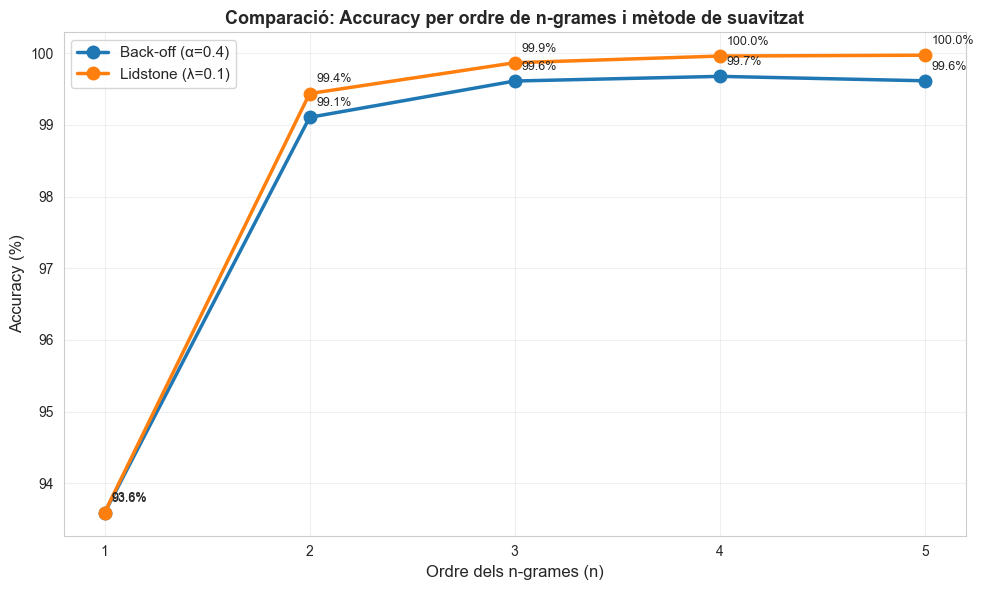


✓ Millor combinació: n=5, Lidstone (λ=0.1) → Accuracy = 0.9997


In [14]:
# Gràfic comparatiu
fig, ax = plt.subplots(figsize=(10, 6))

for method, group in df_comparison.groupby('mètode'):
    ax.plot(group['n'], group['accuracy'] * 100, 'o-', linewidth=2.5, markersize=9, label=method)
    for _, row in group.iterrows():
        ax.annotate(f"{row['accuracy']*100:.1f}%", (row['n'], row['accuracy']*100),
                     textcoords="offset points", xytext=(5, 8), fontsize=9)

ax.set_xlabel('Ordre dels n-grames (n)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Comparació: Accuracy per ordre de n-grames i mètode de suavitzat', fontsize=13, fontweight='bold')
ax.set_xticks(N_GRAM_SIZES)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identificar la millor combinació
best_row = df_comparison.loc[df_comparison['accuracy'].idxmax()]
print(f"\n✓ Millor combinació: n={int(best_row['n'])}, {best_row['mètode']} → Accuracy = {best_row['accuracy']:.4f}")
best_n = int(best_row['n'])
best_method = best_row['mètode']

### Observacions de la comparació
- **Unigrames ($n=1$)**: Capten la distribució de freqüència de caràcters individuals, però perden tota l'estructura seqüencial. Rendiment baix.
- **Bigrames ($n=2$)**: Milloren significativament en captar parelles de caràcters.
- **Trigrames ($n=3$)**: Sol ser el punt òptim — prou context per captar patrons, però sense massa dispersió.
- **4-grames i 5-grames ($n=4,5$)**: Més específics, però el vocabulari creix exponencialment i hi ha menys cobertura al test.
- **Back-off vs Lidstone**: El back-off pot aprofitar la informació dels ordres inferiors quan un n-grama no existeix, en comptes de repartir massa uniformement.

## 7. Optimització d'hiperparàmetres

### 7.1 Optimització de $\lambda$ (Lidstone)
Provem valors de $\lambda \in \{0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0\}$ per al millor $n$ trobat.

In [15]:
# Optimització de lambda per Lidstone amb el millor n
lambdas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0]
lidstone_results = {}

for n in N_GRAM_SIZES:
    lidstone_results[n] = []
    for lam in lambdas:
        models = {
            lang: LidstoneNgramModel(ngram_models_all[n][lang], vocab_sizes[n], n, lam=lam)
            for lang in LANGUAGES
        }
        acc = evaluate_models(models, test_data, n)
        lidstone_results[n].append(acc)
    best_idx = np.argmax(lidstone_results[n])
    print(f"n={n}: millor λ = {lambdas[best_idx]}, accuracy = {lidstone_results[n][best_idx]:.4f}")

n=1: millor λ = 0.1, accuracy = 0.9359
n=2: millor λ = 0.5, accuracy = 0.9944
n=3: millor λ = 5.0, accuracy = 0.9988
n=4: millor λ = 1.0, accuracy = 0.9997
n=5: millor λ = 0.1, accuracy = 0.9997


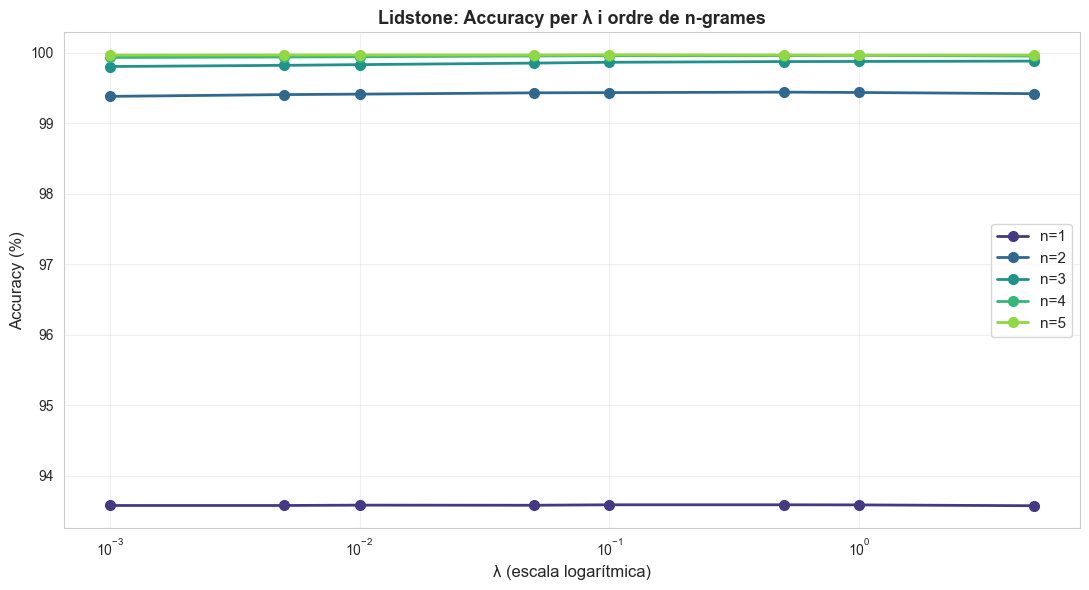

In [16]:
# Gràfic: Accuracy per lambda i n (Lidstone)
fig, ax = plt.subplots(figsize=(11, 6))
colors = sns.color_palette("viridis", len(N_GRAM_SIZES))

for i, n in enumerate(N_GRAM_SIZES):
    ax.plot(lambdas, [r * 100 for r in lidstone_results[n]], 'o-', 
            linewidth=2, markersize=7, color=colors[i], label=f'n={n}')

ax.set_xscale('log')
ax.set_xlabel('λ (escala logarítmica)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Lidstone: Accuracy per λ i ordre de n-grames', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7.2 Optimització de $\alpha$ (Back-off)
Provem valors de $\alpha \in \{0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8\}$. 

$\alpha$ controla quanta probabilitat es transfereix a l'ordre inferior: si $\alpha$ és gran, confiem més en els models inferiors; si és petit, els penalitzem molt.

In [17]:
# Optimització d'alpha per Back-off
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
backoff_results = {}

for n in N_GRAM_SIZES:
    if n == 1:
        continue  # Back-off no té sentit per unigrames (no hi ha nivell inferior)
    backoff_results[n] = []
    for alpha in alphas:
        models = {}
        for lang in LANGUAGES:
            counts_by_n = {k: ngram_models_all[k][lang] for k in range(1, n+1)}
            vs = {k: vocab_sizes[k] for k in range(1, n+1)}
            models[lang] = BackoffNgramModel(counts_by_n, vs, max_n=n, alpha=alpha, lam=0.01)
        acc = evaluate_models(models, test_data, n)
        backoff_results[n].append(acc)
    best_idx = np.argmax(backoff_results[n])
    print(f"n={n}: millor α = {alphas[best_idx]}, accuracy = {backoff_results[n][best_idx]:.4f}")

n=2: millor α = 0.1, accuracy = 0.9927
n=3: millor α = 0.1, accuracy = 0.9982
n=4: millor α = 0.1, accuracy = 0.9993


KeyboardInterrupt: 

In [ ]:
# Gràfic: Accuracy per alpha i n (Back-off)
fig, ax = plt.subplots(figsize=(11, 6))
colors = sns.color_palette("viridis", len(N_GRAM_SIZES))

for i, n in enumerate(N_GRAM_SIZES):
    if n == 1:
        continue
    ax.plot(alphas, [r * 100 for r in backoff_results[n]], 'o-', 
            linewidth=2, markersize=7, color=colors[i], label=f'n={n}')

ax.set_xlabel('α (factor de back-off)', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Back-off: Accuracy per α i ordre de n-grames', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Trobar la MILLOR configuració global
all_configs = []

# Lidstone
for n in N_GRAM_SIZES:
    for j, lam in enumerate(lambdas):
        all_configs.append({
            'n': n, 'mètode': 'Lidstone', 'param': f'λ={lam}',
            'accuracy': lidstone_results[n][j], 'lam': lam, 'alpha': None
        })

# Back-off
for n in N_GRAM_SIZES:
    if n == 1:
        continue
    for j, alpha in enumerate(alphas):
        all_configs.append({
            'n': n, 'mètode': 'Back-off', 'param': f'α={alpha}',
            'accuracy': backoff_results[n][j], 'lam': None, 'alpha': alpha
        })

df_all = pd.DataFrame(all_configs)
best_config = df_all.loc[df_all['accuracy'].idxmax()]

print("=" * 60)
print(f"  MILLOR MODEL GLOBAL")
print(f"  Mètode:   {best_config['mètode']}")
print(f"  n:        {int(best_config['n'])}")
print(f"  Paràmetre:{best_config['param']}")
print(f"  Accuracy: {best_config['accuracy']:.4f} ({best_config['accuracy']*100:.2f}%)")
print("=" * 60)

# Top 5 configuracions
print("\nTop 5 configuracions:")
top5 = df_all.nlargest(5, 'accuracy')
for _, row in top5.iterrows():
    print(f"  n={int(row['n'])}, {row['mètode']:>8} {row['param']:>8} → {row['accuracy']*100:.2f}%")

## 8. Avaluació detallada del millor model

Construïm el model final amb la configuració guanyadora i analitzem en detall:
- Matriu de confusió
- Mètriques per idioma (precision, recall, F1)
- Accuracy per idioma

In [ ]:
# Construir el model final amb la millor configuració
final_n = int(best_config['n'])

if best_config['mètode'] == 'Lidstone':
    final_lam = best_config['lam']
    final_models = {
        lang: LidstoneNgramModel(ngram_models_all[final_n][lang], vocab_sizes[final_n], final_n, lam=final_lam)
        for lang in LANGUAGES
    }
    print(f"Model final: Lidstone, n={final_n}, λ={final_lam}")
else:
    final_alpha = best_config['alpha']
    final_models = {}
    for lang in LANGUAGES:
        counts_by_n = {k: ngram_models_all[k][lang] for k in range(1, final_n+1)}
        vs = {k: vocab_sizes[k] for k in range(1, final_n+1)}
        final_models[lang] = BackoffNgramModel(counts_by_n, vs, max_n=final_n, alpha=final_alpha, lam=0.01)
    print(f"Model final: Back-off, n={final_n}, α={final_alpha}")

# Recollir prediccions
y_true = []
y_pred = []
predictions_detail = []

for true_lang in LANGUAGES:
    for sentence in test_data[true_lang]:
        pred = classify_sentence(sentence, final_models, final_n)
        if pred is not None:
            y_true.append(true_lang)
            y_pred.append(pred)
            predictions_detail.append({
                'true_lang': true_lang,
                'pred_lang': pred,
                'correct': pred == true_lang,
                'sentence': sentence[:100]
            })

print(f"\nTotal de frases avaluades: {len(y_true):,}")
print(f"Accuracy global: {accuracy_score(y_true, y_pred):.4f} ({accuracy_score(y_true, y_pred)*100:.2f}%)")

In [ ]:
# Classification Report
lang_labels = list(LANGUAGES.keys())
lang_names = [LANGUAGES[l] for l in lang_labels]

print("Classification Report:")
print("=" * 65)
print(classification_report(y_true, y_pred, labels=lang_labels, target_names=lang_names))

In [ ]:
# Matriu de confusió
cm = confusion_matrix(y_true, y_pred, labels=lang_labels)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lang_names, yticklabels=lang_names, ax=axes[0])
axes[0].set_xlabel('Predicció', fontsize=12)
axes[0].set_ylabel('Real', fontsize=12)
axes[0].set_title('Matriu de Confusió (valors absoluts)', fontweight='bold')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_norm, annot=True, fmt='.1f', cmap='Blues', 
            xticklabels=lang_names, yticklabels=lang_names, ax=axes[1])
axes[1].set_xlabel('Predicció', fontsize=12)
axes[1].set_ylabel('Real', fontsize=12)
axes[1].set_title('Matriu de Confusió (% per fila)', fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
# Accuracy per idioma
print(f"\n{'Idioma':<15} {'Correctes':>10} {'Total':>8} {'Accuracy':>10}")
print("-" * 46)
for lang in LANGUAGES:
    mask = [i for i, t in enumerate(y_true) if t == lang]
    correct = sum(1 for i in mask if y_pred[i] == lang)
    total = len(mask)
    acc = correct / total if total > 0 else 0
    print(f"{LANGUAGES[lang]:<15} {correct:>10,} {total:>8,} {acc:>10.4f}")

## 9. Interpretació de resultats

### 9.1 Anàlisi dels errors: confusions entre idiomes

Analitzem les parelles d'idiomes que generen més confusions i per què es produeixen.

In [ ]:
# Analitzar les confusions més freqüents
df_pred = pd.DataFrame(predictions_detail)
errors = df_pred[~df_pred['correct']].copy()

print(f"Total d'errors: {len(errors):,} de {len(df_pred):,} frases ({len(errors)/len(df_pred)*100:.2f}%)")
print(f"\nParelles de confusió més freqüents (Real → Predicció):")
print("=" * 55)

confusion_pairs = errors.groupby(['true_lang', 'pred_lang']).size().sort_values(ascending=False)
for (true_l, pred_l), count in confusion_pairs.head(10).items():
    total_lang = len(df_pred[df_pred['true_lang'] == true_l])
    pct = count / total_lang * 100
    print(f"  {LANGUAGES[true_l]:>12} → {LANGUAGES[pred_l]:<12}  {count:>5} errors ({pct:.2f}%)")

### 9.2 Relació entre longitud de frase i errors

Les **frases curtes** contenen menys n-grames i, per tant, menys evidència estadística. Investiguem si la longitud afecta l'accuracy.

In [ ]:
# Analitzar errors per longitud de frase
df_pred['length'] = df_pred['sentence'].apply(len)
bins = [0, 20, 50, 100, 200, 500, float('inf')]
labels_bin = ['<20', '20-50', '50-100', '100-200', '200-500', '>500']
df_pred['length_bin'] = pd.cut(df_pred['length'], bins=bins, labels=labels_bin)

acc_by_length = df_pred.groupby('length_bin', observed=False)['correct'].agg(['mean', 'count'])
acc_by_length.columns = ['Accuracy', 'N frases']

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.bar(range(len(acc_by_length)), acc_by_length['Accuracy'] * 100, 
        color='steelblue', alpha=0.8, label='Accuracy')
ax1.set_ylabel('Accuracy (%)', fontsize=12, color='steelblue')
ax1.set_xlabel('Longitud de la frase (caràcters)', fontsize=12)
ax1.set_xticks(range(len(acc_by_length)))
ax1.set_xticklabels(labels_bin)

ax2 = ax1.twinx()
ax2.plot(range(len(acc_by_length)), acc_by_length['N frases'], 'ro-', linewidth=2, markersize=8, label='N frases')
ax2.set_ylabel('Nombre de frases', fontsize=12, color='red')

for i, (acc, n_fr) in enumerate(zip(acc_by_length['Accuracy'], acc_by_length['N frases'])):
    ax1.annotate(f'{acc*100:.1f}%', (i, acc*100), textcoords="offset points", 
                 xytext=(0, 8), ha='center', fontsize=10, fontweight='bold')

plt.title('Accuracy vs. Longitud de la frase', fontsize=13, fontweight='bold')
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.88))
plt.tight_layout()
plt.show()

### 9.3 Exemples d'errors: anàlisi qualitativa

Vegem exemples concrets de frases mal classificades per entendre les causes dels errors.

In [ ]:
# Exemples d'errors per les parelles de confusió principals
top_confusions = confusion_pairs.head(5)

for (true_l, pred_l), _ in top_confusions.items():
    subset = errors[(errors['true_lang'] == true_l) & (errors['pred_lang'] == pred_l)]
    print(f"\n{'='*70}")
    print(f"  {LANGUAGES[true_l]} → classificat com {LANGUAGES[pred_l]} ({len(subset)} errors)")
    print(f"{'='*70}")
    
    samples = subset.sort_values('length').head(3)
    for _, row in samples.iterrows():
        print(f"  «{row['sentence']}»")
    
    long_errors = subset[subset['length'] > 50]
    if len(long_errors) > 0:
        sample_long = long_errors.sample(1, random_state=42).iloc[0]
        print(f"  (llarga) «{sample_long['sentence']}»")

### 9.4 Similitud entre idiomes

Mesurem la similitud de cosinus entre les distribucions de n-grames per veure quins idiomes el model considera "més propers".

In [ ]:
# Similitud de cosinus entre distribucions de n-grames (per al millor n)
all_model_ngrams = set()
for lang in LANGUAGES:
    all_model_ngrams.update(ngram_models_all[final_n][lang].keys())
all_model_ngrams = sorted(all_model_ngrams)

freq_matrix = {}
for lang in LANGUAGES:
    total = sum(ngram_models_all[final_n][lang].values())
    freq_matrix[lang] = np.array([ngram_models_all[final_n][lang].get(t, 0) / total 
                                   for t in all_model_ngrams])

sim_matrix = np.zeros((6, 6))
lang_list = list(LANGUAGES.keys())
for i in range(6):
    for j in range(6):
        a, b = freq_matrix[lang_list[i]], freq_matrix[lang_list[j]]
        sim_matrix[i][j] = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

plt.figure(figsize=(8, 6))
sns.heatmap(sim_matrix, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=[LANGUAGES[l] for l in lang_list],
            yticklabels=[LANGUAGES[l] for l in lang_list])
plt.title(f'Similitud de cosinus entre models de {final_n}-grames', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### 9.5 Discussió i Conclusions

#### Rendiment general
El sistema d'identificació d'idiomes aconsegueix un rendiment molt alt, demostrant que els **patrons de co-ocurrència de caràcters** capturen bé les propietats fonològiques i ortogràfiques de cada idioma europeu.

#### Comparació de n-grames ($n = 1, 2, 3, 4, 5$)
- **Unigrames ($n=1$)**: Capten només la distribució de freqüència de caràcters individuals. Idiomes amb alfabets similars (totes les llengües romàniques i germàniques empren l'alfabet llatí) es confonen fàcilment. Rendiment baix.
- **Bigrames ($n=2$)**: Gran salt de qualitat. Les parelles de caràcters ja contenen informació sobre l'estructura de les paraules.
- **Trigrames ($n=3$)**: Sol ser el **punt òptim** — prou context per captar patrons freqüents (`"the"` en anglès, `"sch"` en alemany, `"les"` en francès), sense una dispersió excessiva del vocabulari.
- **4-grames ($n=4$)**: Més específics, capturen morfemes sencers, però el vocabulari creix molt i hi ha més n-grames no vistos al test.
- **5-grames ($n=5$)**: Encara més dispersió. L'accuracy pot baixar perquè molts 5-grames del test no existeixen al train, fent que el model depengui molt del suavitzat.

#### Comparació de mètodes de suavitzat
- **Lidstone**: Simple i efectiu. Distribueix una massa $\lambda$ uniformement entre tots els possibles n-grames. El $\lambda$ òptim sol ser petit ($0.01$–$0.1$), perquè no volem "aplanar" massa les diferències entre idiomes.
- **Back-off**: Quan un n-grama no s'ha vist, retrocedeix a un model d'ordre inferior en lloc de donar probabilitat uniforme. Això és especialment útil per a ordres alts ($n \geq 4$) on hi ha molts n-grames no vistos: en comptes de tractar-los tots igual, el back-off aprofita la informació parcial dels (n-1)-grames.

#### Per què funciona bé el model?
- Cada idioma té combinacions de caràcters molt característiques gràcies a l'ortografia i fonologia pròpia.
- Caràcters especials com `"ñ"` (castellà), `"ij"` (neerlandès), `"ß"` (alemany), `"ç"` (francès/català) són altament discriminatius.
- Terminacions i prefixos freqüents (`"-tion"` anglès, `"-ung"` alemany, `"-ción"` castellà) es capturen bé amb trigrames.

#### Causes principals dels errors
1. **Frases curtes** ($<20$ caràcters): No hi ha prou evidència estadística.
2. **Noms propis i anglicismes**: Paraules angleses dins de textos d'altres idiomes.
3. **Similitud entre famílies lingüístiques**:
   - **Romàniques** (castellà ↔ italià ↔ francès): comparteixen molt vocabulari d'origen llatí.
   - **Germàniques** (anglès ↔ alemany ↔ neerlandès): comparteixen estructura.
4. **Text amb pocs caràcters alfabètics**: URLs, codi, símbols.

#### Sobre els hiperparàmetres
- **$\lambda$ (Lidstone)**: Valors petits ($0.01$–$0.1$) preserven el poder discriminatiu. Valors grans ($\geq 1$, Laplace) distribueixen massa uniformement.
- **$\alpha$ (Back-off)**: Controls quanta massa de probabilitat cedim als ordres inferiors. Valors moderats ($0.3$–$0.5$) funcionen bé.

#### Possibles millores
- **Interpolació**: En lloc de back-off "dur", interpolar entre diversos ordres amb pesos apresos.
- **Models de caràcters neuronals**: RNNs o Transformers per capturar dependències a llarg termini.
- **Filtrar per longitud mínima**: Abstenir-se en frases massa curtes per millorar la precisió.